# Lecture 06: Examples and overview

[Download on GitHub](https://github.com/NumEconCopenhagen/lectures-2022)

[<img src="https://mybinder.org/badge_logo.svg">](https://mybinder.org/v2/gh/NumEconCopenhagen/lectures-2022/master?urlpath=lab/tree/06/Examples_and_overview.ipynb)

1. [Recap](#Recap)
2. [The consumer problem](#The-consumer-problem)
3. [A worker-capitalist production economy](#A-worker-capitalist-production-economy)
4. [Inaugural project from 2020 (labor supply and taxation)](#Inaugural-project-from-2020-(labor-supply-and-taxation))
5. [Summary](#Summary)


You now have all the basic tools to solve interesting economic models. The trick is to be able to combine what you know to solve problems in practice. We firstly briefly recap, with a focus solving optimization problems and non-linear equations. Afterwards, we consider a number of examples.

1. The consumer problem
2. A worker-capitalist production economy
3. The inaugurual project from 2020 (labor supply and taxation)

In [1]:
# magic to reload modules automatically
%load_ext autoreload
%autoreload 2

# standard imports
from types import SimpleNamespace # new? explained below
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

<a id="Recap"></a>

# 1. Recap

2. **Primitives:** types, operators, copy vs. view, conditionals, loops, functions, classes
3. **Optimize, print and plot:** mathematics (numpy), printing, figures (matplotlib), solving optimization problems and equations (scipy.optimize)
4. **Random numbers and simulation:** random numbers (numpy.random), save/load (pickle), interactive figures (ipywidgets)
5. **Workflow and debugging:** structuring, naming, commenting, debugging (assert, try-except), modules

**Sum up:** Lots and lots of information. The important thing is not to remember it all, but to know where to look for answers.

## 1.1 Optimize, optimize, optimize

**The two most important tools:** 

1. Solving optimization problems with `scipy.optimize.minimize` and `scipy.optimize.minimize_scalar`
2. Solving equations with `scipy.optimize.root` and `scipy.optimize.root_scalar`

**Problem:** A bit of a black box...

* **Lecture 10:** Details on solving equations.
* **Lecture 11:** Details on numerical optimization.
* **Now:** Compare with a) a *loop search* and b) a *hand-written optimizer*.

### Loops vs. optimizer

**Consider a simple maximization problem:** 

$$
\max_x f(x) = \max_x -3(x-2)^2+1
$$

**Solution:**

$$
f^\prime(x) = 0 \Leftrightarrow -6(x-2) = 0 \Leftrightarrow x = 2.0
$$

In [2]:
def f_func(x):
    return -3*(x-2)**2 + 1

**Rough solution with loop:**

In [3]:
N = 100
x_vec = np.linspace(-10,10,N)
f_vec = np.empty(N)

f_best = -np.inf # initial maximum
x_best = np.nan # not-a-number

for i,x in enumerate(x_vec):
    f_now = f_vec[i] = f_func(x)
    if f_now > f_best:
        x_best = x
        f_best = f_now

print(f'best with loop is {f_best:.8f} at x = {x_best:.8f}')

best with loop is 0.98041016 at x = 1.91919192


**Question:** Not quite right, how to improve?

**Plot:**

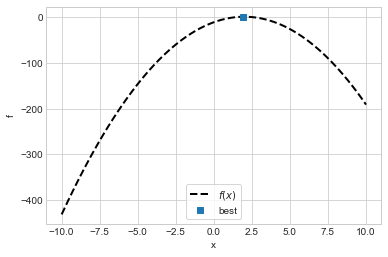

In [4]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(x_vec,f_vec,ls='--',lw=2,color='black',label='$f(x)$')
ax.plot(x_best,f_best,ls='',marker='s',label='best')

ax.set_xlabel('x')
ax.set_ylabel('f')
ax.legend(loc='lower center',frameon=True);

**Solution with** `scipy.optimize.minimize_scalar` ([documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize_scalar.html#scipy.optimize.minimize_scalar)):

In [5]:
obj = lambda x: -f_func(x) # here the input is a scalar
res = optimize.minimize_scalar(obj,bracket=(-10,10),method='brent')
x = res.x
f = -res.fun

print(f'best is {f:.8f} at x = {x:.8f}')

best is 1.00000000 at x = 2.00000000


**Solution with** `scipy.optimize.minimize` ([documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize)):

In [6]:
x_guess = [0]
obj = lambda x: -f_func(x[0]) # now the input is a vector
res = optimize.minimize(obj,x_guess,method='Nelder-Mead')
x = res.x[0]
f = -res.fun

print(f'best is {f:.8f} at x = {x:.8f}')

best is 1.00000000 at x = 2.00000000


**Solution with** `scipy.optimize.root_scalar` ([documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.root_scalar.html)):

Find derivative and solve via FOC:

In [7]:
def fp_func(x):
    return -6*(x-2)

In [8]:
obj = lambda x: fp_func(x)
res = optimize.root_scalar(obj,bracket=(-10,10),method='bisect')
x = res.root
f = f_func(res.root)

print(f'best is {f:.8f} at x = {x:.8f}')

best is 1.00000000 at x = 2.00000000


**Solution with** `scipy.optimize.root` ([documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.root.html)):

In [9]:
x_guess = [0]    
obj = lambda x: fp_func(x[0])
res = optimize.root(obj,x_guess,method='hybr')
x = res.x[0]
f = f_func(x)

print(f'best is {f:.8f} at x = {x:.8f}')

best is 1.00000000 at x = 2.00000000


### Gradient descent optimizer

**Algorithm:** `minimize_gradient_descent()`

1. Choose tolerance $\epsilon>0$, step size $\alpha > 0$, and guess on $x_0$, set $n=0$.
2. Compute  $f(x_n)$ and $f^\prime(x_n) \approx \frac{f(x_n+\Delta)-f(x_n)}{\Delta}$.
3. If $|f^\prime(x_n)| < \epsilon$ then stop.
4. Compute new guess "down the hill":

  $$
  x_{n+1} = x_{n} - \alpha f^\prime(x_n)
  $$


5. Set $n = n + 1$ and return to step 2.

**Code for algorithm:**

In [10]:
def gradient_descent(f,x0,alpha=0.5,Delta=1e-8,max_iter=500,eps=1e-8):
    """ minimize function with gradient descent
        
    Args:

        f (callable): function
        x0 (float): initial value
        alpha (float,optional): step size factor in search
        Delta (float,optional): step size in numerical derivative
        max_iter (int,optional): maximum number of iterations
        eps (float,optional): tolerance
        
    Returns:
    
        x (float): minimum
        fx (float): funciton value at minimum
        trials (list): og dicts with keys x, value and derivative
        
    """
    
    # step 1: initialize
    x = x0
    n = 0
    trials = []
    
    # step 2-4:
    while n < max_iter:
            
        # step 2: compute function value and derivative
        fx = f(x)
        fp = (f(x+Delta)-fx)/Delta
        
        trials.append({'x':x,'fx':fx,'fp':fp}) 
        
        # step 3: check convergence
        print(f'n = {n:3d}: x = {x:12.8f}, f = {fx:12.8f}, fp = {fp:12.8f}')
        if np.abs(fp) < eps:
            break
                  
        # step 4: update x
        x -= alpha*fp
        
        # step 5: update n
        n += 1
        
    return x,fx,trials

**New example:**

$$
\max_x f(x) = \max_x -\sin(x)+0.05x^2
$$

**Call the optimizer:**

In [11]:
x0 = 0.0
f = lambda x: -np.sin(x)+0.05*x**2

x,fx,trials = gradient_descent(f,x0)

print(f'best with gradient_descent is {fx:.8f} at x = {x:.8f}')

n =   0: x =   0.00000000, f =   0.00000000, fp =  -1.00000000
n =   1: x =   0.50000000, f =  -0.46692554, fp =  -0.82758256
n =   2: x =   0.91379128, f =  -0.75007422, fp =  -0.51936899
n =   3: x =   1.17347578, f =  -0.85324884, fp =  -0.26960142
n =   4: x =   1.30827649, f =  -0.88015974, fp =  -0.12868722
n =   5: x =   1.37262010, f =  -0.88622298, fp =  -0.05961956
n =   6: x =   1.40242988, f =  -0.88751934, fp =  -0.02732913
n =   7: x =   1.41609444, f =  -0.88779134, fp =  -0.01247611
n =   8: x =   1.42233250, f =  -0.88784799, fp =  -0.00568577
n =   9: x =   1.42517538, f =  -0.88785975, fp =  -0.00258928
n =  10: x =   1.42647003, f =  -0.88786219, fp =  -0.00117876
n =  11: x =   1.42705940, f =  -0.88786269, fp =  -0.00053654
n =  12: x =   1.42732767, f =  -0.88786280, fp =  -0.00024420
n =  13: x =   1.42744978, f =  -0.88786282, fp =  -0.00011116
n =  14: x =   1.42750535, f =  -0.88786283, fp =  -0.00005059
n =  15: x =   1.42753065, f =  -0.88786283, fp =  -0.0

**Illusstration:**

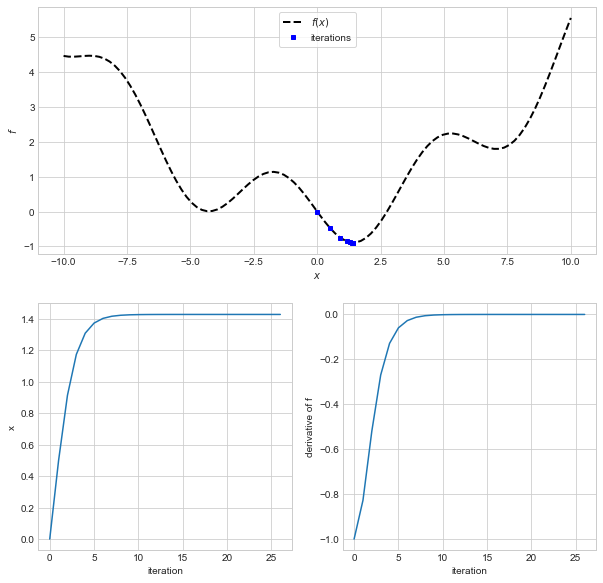

In [12]:
fig = plt.figure(figsize=(10,10))

# a. main figure
ax = fig.add_subplot(2,2,(1,2))

trial_x_vec = [trial['x'] for trial in trials]
trial_f_vec = [trial['fx'] for trial in trials]
trial_fp_vec = [trial['fp'] for trial in trials]

ax.plot(x_vec,f(x_vec),ls='--',lw=2,color='black',label='$f(x)$')
ax.plot(trial_x_vec,trial_f_vec,ls='',marker='s',ms=4,color='blue',label='iterations')

ax.set_xlabel('$x$')
ax.set_ylabel('$f$')
ax.legend(loc='upper center',frameon=True)

# sub figure 1
ax = fig.add_subplot(2,2,3)
ax.plot(np.arange(len(trials)),trial_x_vec)
ax.set_xlabel('iteration')
ax.set_ylabel('x')

# sub figure 2
ax = fig.add_subplot(2,2,4)
ax.plot(np.arange(len(trials)),trial_fp_vec)
ax.set_xlabel('iteration')
ax.set_ylabel('derivative of f');

**Question:** Can we guess on any initial value of $x_0$?

**What to take a look inside?** Turn on the [debugger](https://jupyterlab.readthedocs.io/en/stable/user/debugger.html). Add a *breakpoint* in the beginning of `gradient_descent`. Solve the problem again, and *step in* by pressing `F11`.

<a id="The-consumer-problem"></a>

# 2. The consumer problem

$$
\begin{aligned}
V(p_{1},p_{2},m) & = \max_{x_{1},x_{2}} \left(\alpha^{\frac{1}{\sigma}}x_{1}^{\frac{\sigma-1}{\sigma}}+(1-\alpha)^{\frac{1}{\sigma}}x_{2}^{\frac{\sigma-1}{\sigma}}\right)^{\frac{\sigma}{\sigma-1}}\\
 \text{s.t.}\\
p_{1}x_{1}+p_{2}x_{2} & \leq m,\,\,\,p_{1},p_{2},m>0\\
x_{1},x_{2} & \geq 0
\end{aligned}
$$

**Goal:** Create a model-class to solve this problem.

1. Let `model` be a class
1. Let `model.par` contain all parameters (e.g. `model.par.alpha`)
1. Let `model.sol` contain the solution (e.g. `model.sol.x1`)

**SimpleNamespace():** Like a dictionary, but e.g. `par.alpha` instead of `par['alpha']`.  

In [13]:
par = SimpleNamespace()
par.alpha = 0.5
par.sigma = 0.1

print(f'alpha = {par.alpha:6.3f}')
print(f'sigma = {par.sigma:6.3f}')

alpha =  0.500
sigma =  0.100


Can always be interfaced as a dictionary with `__dict__`:

In [14]:
for k,v in par.__dict__.items():
    print(f'{k:5s} = {v:6.3f}')

alpha =  0.500
sigma =  0.100


**Utility function:**

In [15]:
def u_func(model,x1,x2):
    
    par = model.par
    
    u_x1 = par.alpha**(1/par.sigma)*x1**((par.sigma-1)/par.sigma)
    u_x2 = (1-par.alpha)**(1/par.sigma)*x2**((par.sigma-1)/par.sigma)
    
    return (u_x1+u_x2)**(par.sigma/(par.sigma-1))

**Solution function:**

In [16]:
def solve(model):
    
    par = model.par
    sol = model.sol    
    
    # a. objective function (to minimize) 
    obj = lambda x: -model.u_func(x[0],x[1]) # minimize -> negtive of utility
        
    # b. constraints and bounds
    budget_constraint = lambda x: par.m-par.p1*x[0]-par.p2*x[1] # violated if negative
    constraints = ({'type':'ineq','fun':budget_constraint})
    bounds = ((1e-8,par.m/par.p1-1e-8),(1e-8,par.m/par.p2-1e-8))
    
    # why all these 1e-8? To avoid ever having x1 = 0 or x2 = 0
    
    # c. call solver
    x0 = [(par.m/par.p1)/2,(par.m/par.p2)/2]
    result = optimize.minimize(obj,x0,method='SLSQP',bounds=bounds,constraints=constraints)
        
    # d. save
    sol.x1 = result.x[0]
    sol.x2 = result.x[1]
    sol.u = model.u_func(sol.x1,sol.x2)

**Create consumer class:**

In [17]:
class ConsumerClass:
    
    def __init__(self): 
        
        # this is called automatically when a consumer is created
        
        # a. parameters
        par = self.par = SimpleNamespace()
        par.alpha = 0.5
        par.sigma = 0.1
        par.mu = 0.5
        par.p1 = 1
        par.p2 = 2
        par.m = 10

        # b. solution
        sol = self.sol = SimpleNamespace()
        sol.x1 = np.nan
        sol.x2 = np.nan
        sol.u = np.nan
        
    u_func = u_func
    solve = solve
    

**Solve consumer problem**:

In [18]:
jeppe = ConsumerClass() # calls __init__()
jeppe.solve()
print(f'(x1,x2) = ({jeppe.sol.x1:.3f},{jeppe.sol.x2:.3f}), u = {jeppe.sol.u:.3f}')

(x1,x2) = (3.489,3.256), u = 6.705


Easy to loop over:

In [19]:
for alpha in np.linspace(0.3,0.7,5):
    jeppe.par.alpha = alpha
    jeppe.solve()
    print(f'alpha = {alpha:.3f} -> (x1,x2) = ({jeppe.sol.x1:.3f},{jeppe.sol.x2:.3f}), u = {jeppe.sol.u:.3f}')

alpha = 0.300 -> (x1,x2) = (1.868,4.066), u = 5.906
alpha = 0.400 -> (x1,x2) = (2.632,3.684), u = 6.282
alpha = 0.500 -> (x1,x2) = (3.489,3.256), u = 6.705
alpha = 0.600 -> (x1,x2) = (4.456,2.772), u = 7.186
alpha = 0.700 -> (x1,x2) = (5.556,2.222), u = 7.737


**Question:** Anything you want to test?

<a id="A-worker-capitalist-production-economy"></a>

# 3. A worker-capitalist production economy

Consider an economy consisting of $N_w$ **workers**, and $N_c$ **capitalists** and a single **firm** owned equally by the capitalists.

**Workers:** Consume, $c_w$, at a price $p$, and supply labor, $\ell_w$, at a wage of $w$. Maximize utility:
        
$$\max_{c_w\geq0,\ell_w\in[0,1]} \log (c_w+\kappa)- \omega \ell_w^{\eta} \text{ s.t } pc_w \leq w \ell_w,\,\,\,\omega,\kappa > 0, \eta \geq 1$$ 

Equivalently, substituting in the budget constraint with equality:

$$\max_{\ell_w\in[0,1]} \log \left( \frac{w \ell_w}{p}+\kappa \right)- \omega \ell_w^{\eta}$$ 

Denote ***optimal behavior*** $c_w^{\star}(p,w)$ and $\ell_w^{\star}(p,w)$.

**Capitalists:** Consume, $c_c$, at a price $p$, supply labor, $\ell_c$, at a wage $w$, and receives profits $\pi$. Maximize utility:
        
$$\max_{c_c\geq0,\ell_c\in[0,1]} \log (c_c+\kappa) - \omega \ell_c^{\eta} \text{ s.t } pc_c = w \ell_c + \pi, ,\,\,\,\omega,\kappa > 0, \eta \geq 1$$ 

Equivalently, substituting in the budget constraint with equality:

$$\max_{\ell_c\in[0,1]} \log \left( \frac{w \ell_c + \pi}{p}+\kappa \right)- \omega \ell_c^{\eta}$$ 

Denote ***optimal behavior*** $c_c^{\star}(p,w,\pi)$ and $\ell_c^{\star}(p,w,\pi)$.

**Firm:** Use the production function $f(\ell) = \ell^\alpha, \alpha \in (0,1)$. Maximize profits:

$$\max_{\ell\geq0} p f(\ell) - w\ell $$ 

Denote ***optional behavior*** by $\ell^{\star}(p,w)$. 

Implied ***production*** is $y^{\star}(p,w) = f(\ell^{\star}(p,w))$ and implied ***total profits*** are $\Pi^\star(p,w) = py^{\star}(p,w) - w\ell^{\star}(p,w)$ 

**Equilibrium:** A set of prices $(p,w)$ such that workers, capitalists and firms act optimally given prices and profit, and

1. **Goods market clears**: $N_w c_w^{\star}(p,w) + N_c c_c^{\star}(p,w,\pi) = y^\star(p,w)$
2. **Labor market clears**: $N_w \ell_w^{\star}(p,w) + N_c \ell_c^{\star}(p,w,\pi) = \ell^\star(p,w)$
3. **Profits received equal profits distributed**: $\pi = \frac{py^{\star}(p,w) - w\ell^{\star}(p,w)}{N_c}$

**Note I:** We can use $p=1$ as numeraire.

**Note II:** *Walras' Law* imply that if one of the markets clear, then the other one does too.

## 3.1 Parameters

Choose parameters:

In [20]:
par = SimpleNamespace()
par.kappa = 0.1
par.omega = 10
par.eta = 1.50
par.alpha = 0.50
par.Nw = 99
par.Nc = 1

## 3.2 Workers

In [21]:
def utility_w(c,l,par):
    """ utility of workers """
    
    return np.log(c+par.kappa)-par.omega*l**par.eta

def workers(p,w,par):
    """ maximize utility for workers """
    
    # a. solve
    obj = lambda l: -utility_w((w*l)/p,l,par)
    res = optimize.minimize_scalar(obj,bounds=(0,1),method='bounded')
    
    # b. save
    l_w_star = res.x
    c_w_star = (w*l_w_star)/p
    
    return c_w_star,l_w_star

**Small test:**

In [22]:
p = 1
for w in [0.5,1,1.5]:
    c,l = workers(p,w,par)
    print(f'w = {w:.2f} -> c = {c:.2f}, l = {l:.2f}')

w = 0.50 -> c = 0.03, l = 0.06
w = 1.00 -> c = 0.11, l = 0.11
w = 1.50 -> c = 0.18, l = 0.12


## 3.3 Capitalists

In [23]:
def utility_c(c,l,par):
    """ utility of capitalists """
    
    return np.log(c+par.kappa)-par.omega*l**par.eta

def capitalists(p,w,pi,par):
    """ maximize utility of capitalists """
    
    # a. solve
    obj = lambda l: -utility_c((w*l+pi)/p,l,par) # subsittute in the budget constraint
    res = optimize.minimize_scalar(obj,bounds=(0,1),method='bounded')
    
    # b. save
    l_c_star = res.x
    c_c_star = (w*l_c_star+pi)/p
    
    return c_c_star,l_c_star

**Small test:**

In [24]:
p = 1
pi = 0.1
for w in [0.5,1,1.5]:
    c,l = capitalists(p,w,pi,par)
    print(f'w = {w:.2f} -> c = {c:.2f}, l = {l:.2f}')

w = 0.50 -> c = 0.11, l = 0.02
w = 1.00 -> c = 0.16, l = 0.06
w = 1.50 -> c = 0.23, l = 0.09


**Question:** Any idea for another test?

## 3.4 Firm

In [25]:
def firm(p,w,par):
    """ maximize firm profits """
    
    # a. solve
    f = lambda l: l**par.alpha
    obj = lambda l: -(p*f(l)-w*l)
    x0 = [0.0]
    res = optimize.minimize(obj,x0,bounds=((0,None),),method='L-BFGS-B')
    
    # b. save
    l_star = res.x[0]
    y_star = f(l_star)
    Pi = p*y_star - w*l_star
    
    return y_star,l_star,Pi

**Small test:**

In [26]:
p = 1
for w in [0.5,1,1.5]:
    y,l,Pi = firm(p,w,par)
    print(f'w = {w:.2f} -> y = {y:.2f}, l = {l:.2f}, Pi = {Pi:.2f}')

w = 0.50 -> y = 1.00, l = 1.00, Pi = 0.50
w = 1.00 -> y = 0.50, l = 0.25, Pi = 0.25
w = 1.50 -> y = 0.33, l = 0.11, Pi = 0.17


## 3.5 Equilibrium

In [27]:
def evaluate_equilibrium(w,par,p=None,do_print=False):
    """ evaluate equilirium """
    
    # a. normalize output price
    p = 1 if p is None else p
    
    # b. optimal behavior of firm
    y_star,l_star,Pi = firm(p,w,par)
    pi = Pi/par.Nc
    
    # c. optimal behavior of households
    c_w_star,l_w_star = workers(p,w,par)
    c_c_star,l_c_star = capitalists(p,w,pi,par)
    
    # d. market clearing
    goods_mkt_clearing = par.Nw*c_w_star + par.Nc*c_c_star - y_star
    labor_mkt_clearing = par.Nw*l_w_star + par.Nc*l_c_star - l_star
    
    if do_print:
        
        u_w = utility_w(c_w_star,l_w_star,par)
        print(f'workers      : c = {c_w_star:6.4f}, l = {l_w_star:6.4f}, u = {u_w:7.4f}')
        u_c = utility_c(c_c_star,l_c_star,par)
        print(f'capitalists  : c = {c_c_star:6.4f}, l = {l_c_star:6.4f}, u = {u_c:7.4f}')        
        print(f'goods market : {goods_mkt_clearing:.8f}')
        print(f'labor market : {labor_mkt_clearing:.8f}')
        
    else:
    
        return goods_mkt_clearing


**Step 1:** Perform rough grid search to check when the goods market clears.

In [28]:
num_w = 10
grid_w = np.linspace(0.1,1.5,num_w)
grid_mkt_clearing = np.zeros(num_w)

for i,w in enumerate(grid_w):
    grid_mkt_clearing[i] = evaluate_equilibrium(w,par)
    print(f'w = {w:.2f} -> excess demand = {grid_mkt_clearing[i]:12.8f}')

w = 0.10 -> excess demand =  -2.45597063
w = 0.26 -> excess demand =  -0.33115179
w = 0.41 -> excess demand =   1.47824268
w = 0.57 -> excess demand =   3.60037473
w = 0.72 -> excess demand =   5.89988125
w = 0.88 -> excess demand =   8.29317023
w = 1.03 -> excess demand =  10.74049294
w = 1.19 -> excess demand =  13.22157416
w = 1.34 -> excess demand =  15.72439188
w = 1.50 -> excess demand =  18.24150339


**Step 2:** Find where *excess demand* changes sign - the equilibrium price must be within this range

In [29]:
left = np.max(grid_w[grid_mkt_clearing < 0])
right = np.min(grid_w[grid_mkt_clearing > 0])
print(f'equilibrium price must be in [{left:.2f},{right:.2f}]')

equilibrium price must be in [0.26,0.41]


**Step 3:** Use equation-solver / root-finder

In [30]:
res = optimize.root_scalar(evaluate_equilibrium,bracket=[left,right],method='bisect',args=(par,))
w = res.root
print(f'the equilibrium wage is {w:.4f}')

the equilibrium wage is 0.2864


**Show details:**

In [31]:
evaluate_equilibrium(w,par,do_print=True)

workers      : c = 0.0088, l = 0.0308, u = -2.2721
capitalists  : c = 0.8731, l = 0.0004, u = -0.0274
goods market : 0.00000004
labor market : 0.00000013


**Check I:** Does both markets clear?

**Check II:** Can we multiply both prices with the same factor? I.e. can we change the numeraire?

In [32]:
fac = 100
p_ = fac*1.0 
w_ = fac*w
evaluate_equilibrium(w_,par,p=p_,do_print=True)

workers      : c = 0.0088, l = 0.0308, u = -2.2721
capitalists  : c = 0.8731, l = 0.0004, u = -0.0274
goods market : -0.00000240
labor market : -0.00000840


## 3.6 Experiments

It is easy to extend this model in many directions: 

1. Should workers and capitalists have different tastes or producitvity?
1. Should there be government redistribution?
2. Other ideas?

## 3.7 Using a class

In [33]:
from WorkerCapitalistEconomy import WorkerCapitalistEconomyClass

**Look at `WorkerCapitalistEconomy.py`:** Same code, but written as a class! 

In [34]:
model = WorkerCapitalistEconomyClass()
print(model.par.kappa) # excess the class data with .

0.1


In [35]:
model.find_equilibrium()

grid search:
 w = 0.10 ->  -2.45597063
 w = 0.26 ->  -0.33115179
 w = 0.41 ->   1.47824268
 w = 0.57 ->   3.60037473
 w = 0.72 ->   5.89988125
 w = 0.88 ->   8.29317023
 w = 1.03 ->  10.74049294
 w = 1.19 ->  13.22157416
 w = 1.34 ->  15.72439188
 w = 1.50 ->  18.24150339

equilibrium price must be in [0.26,0.41]

the equilibrium wage is 0.2864

workers      : c = 0.0088, l = 0.0308, u = -2.2721
capitalists  : c = 0.8731, l = 0.0004, u = -0.0274
goods market : 0.00000004
labor market : 0.00000013


**Benefit I:** Fewer inputs and outputs, less risk of wrong ordering.

**Benefit II of class-based solution:** Easy access to all data.
E.g. capitalists share of total consumption.

In [36]:
C_w = model.par.Nw*model.sol.c_w_star
C_c = model.par.Nc*model.sol.c_c_star
print(f'capitalists share of total consumption is: {C_c/(C_c+C_w):.2f}')

capitalists share of total consumption is: 0.50


**Benefit III of class-based solution:** Easy to experiment with different parameters.

In [37]:
model.par.kappa = model.par.kappa/100 # lower kappa
model.find_equilibrium()

grid search:
 w = 0.10 ->  -0.93720172
 w = 0.26 ->   3.11578788
 w = 0.41 ->   6.01856761
 w = 0.57 ->   8.72067391
 w = 0.72 ->  11.35650742
 w = 0.88 ->  13.96702518
 w = 1.03 ->  16.56693675
 w = 1.19 ->  19.16044548
 w = 1.34 ->  21.74865061
 w = 1.50 ->  24.33227156

equilibrium price must be in [0.10,0.26]

the equilibrium wage is 0.1260

workers      : c = 0.0200, l = 0.1592, u = -4.4959
capitalists  : c = 1.9848, l = 0.0000, u =  0.6860
goods market : 0.00000037
labor market : 0.00000291


In [38]:
for k,v in model.sol.__dict__.items():
    print(f'{k:20s} = {v:6.2f}')

p                    =   1.00
w                    =   0.13
l_star               =  15.76
y_star               =   3.97
Pi                   =   1.98
pi                   =   1.98
l_w_star             =   0.16
c_w_star             =   0.02
l_c_star             =   0.00
c_c_star             =   1.98
goods_mkt_clearing   =   0.00
labor_mkt_clearing   =   0.00


<a id="Inaugural-project-from-2020-(labor-supply-and-taxation)"></a>

# 4. Inaugural project from 2020 (labor supply and taxation)

Consider a consumer solving the following maximization problem

$$\begin{eqnarray}
c^{\star},\ell^{\star} & = & \arg\max_{c,\ell}\log(c)-\nu\frac{\ell^{1+\frac{1}{\varepsilon}}}{1+\frac{1}{\varepsilon}}\\
 & \text{s.t.} \\
x & = & m+w\ell-\left[\tau_{0}w\ell+\tau_{1}\max\{w\ell-\kappa,0\}\right] \\
c & \in & [0,x] \\
\ell & \in & [0,1]
\end{eqnarray}$$

where $c$ is consumption, $\ell$ is labor supply, $m$ is cash-on-hand,
$w$ is the wage rate, $\tau_{0}$ is the standard labor income tax,
$\tau_{1}$ is the top bracket labor income tax, $\kappa$ is the
cut-off for the top labor income bracket, $x$ is total resources,
$\nu$ scales the disutility of labor, and $\varepsilon$ is the Frisch
elasticity of labor supply.

Note that utility is monotonically increasing in consumption. This implies that
$$\begin{equation}
c^{\star}=x
\end{equation}$$

**Question 1:** Construct a function which solves the consumer given the parameters.

We choose the following parameter values

$$
m=1,\,\nu=10,\,\varepsilon=0.3,\,\tau_{0}=0.4,\,\tau_{1}=0.1,\,\kappa=0.4
$$

**Question 2:** Plot $\ell^{\star}$ and $c^{\star}$ as functions of $w$ in
the range $0.5$ to $1.5$.

Consider a population with $N=1,000$ individuals indexed by $i$.

Assume the distribution of wages is uniform such that

$$w_{i}\sim\mathcal{U}(0.5,1.5).$$

Denote the optimal choices of individual $i$ by $\ell_{i}^{\star}$ and $c_{i}^{\star}$.


**Question 3:** Calculate the total tax revenue given by $T=\sum_{i=1}^{N}\left[\tau_{0}w_{i}\ell_{i}^{\star}+\tau_{1}\max\{w_{i}\ell_{i}^{\star}-\kappa,0\}\right].$

**Question 4:** What would the tax revenue be if instead $\varepsilon=0.1$?

Consider a politician who wishes to maximize the tax revenue.

**Question 5:** Which $\tau_{0}$, $\tau_{1}$ and $\kappa$ would you suggest her to implement? Report the tax revenue you expect to obtain.

## 4.1 Solution of question 1+2

All the basic functions are written in `LaborSupplyModel.py`.

In [39]:
import LaborSupplyModel as LSM

Define all **parameters**:

In [40]:
m = 1
nu = 10
frisch = 0.3
tau0 = 0.4
tau1 = 0.1
kappa = 0.4

**Allocate** arrays for solutions:

In [41]:
N = 1_000
w_vec = np.linspace(0.5,1.5,N)
l_vec = np.zeros(N)
c_vec = np.zeros(N)

**Solve:**

In [42]:
for i in range(N):
    l_vec[i] = LSM.find_optimal_labor_supply(nu,frisch,m,w_vec[i],tau0,tau1,kappa)
    c_vec[i] = LSM.implied_c(l_vec[i],m,w_vec[i],tau0,tau1,kappa)

**Plot results:**

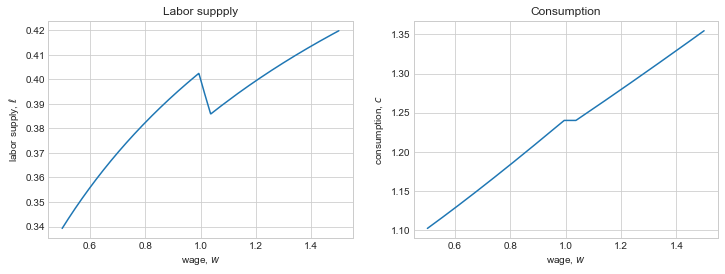

In [43]:
fig = plt.figure(figsize=(12,4))

ax = fig.add_subplot(1,2,1)
ax.plot(w_vec,l_vec,'-')
ax.set_ylabel('labor supply, $\ell$')
ax.set_xlabel('wage, $w$')
ax.set_title('Labor suppply')

ax = fig.add_subplot(1,2,2)
ax.plot(w_vec,c_vec,'-')
ax.set_ylabel('consumption, $c$')
ax.set_xlabel('wage, $w$')
ax.set_title('Consumption');

## 4.2 Solution of question 3

Calculate **tax revnue** using that a equally spaced vector approximates a uniform distribution: 

In [44]:
T = np.sum(LSM.implied_tax(l_vec,w_vec,tau0,tau1,kappa))
print(f'total tax revenue is: {T:.4f}')

total tax revenue is: 163.0262


Using **random sampling** is also a possibility:

In [45]:
# a. set seed
np.random.seed(1917)

# b. run replications
reps = 50
T_vec = np.zeros(reps)
for rep in range(reps):
    
    # i. draw randow wages
    w_vec_ = np.random.uniform(0.5,1.5,size=N)
    
    # ii. find labor supply
    l_vec_ = np.zeros(N)
    for i in range(N):
        l_vec_[i] = LSM.find_optimal_labor_supply(nu,frisch,m,w_vec_[i],tau0,tau1,kappa)

    # iii. find tax revenue
    T_vec[rep] = np.sum(LSM.implied_tax(l_vec_,w_vec_,tau0,tau1,kappa))
    
    if rep < 10 or rep%10 == 0:
        print(f'{rep:2d}: {T_vec[rep]:.4f}')

# c. mean
print(f'mean: {np.mean(T_vec):.4f} [{np.min(T_vec):.4f} {np.max(T_vec):.4f}]')

 0: 159.7256
 1: 164.1675
 2: 166.3045
 3: 164.1948
 4: 162.4999
 5: 162.3964
 6: 164.1743
 7: 162.2987
 8: 163.5471
 9: 159.5859
10: 165.9245
20: 165.1277
30: 162.2696
40: 160.8294
mean: 162.8388 [159.4760 166.3045]


## 4.3 Question 4

**Re-solve** with $\epsilon = 0.1$:

In [46]:
frisch_low = 0.1
l_vec_frisch_low = np.zeros(N)
for i in range(N):
    l_vec_frisch_low[i] = LSM.find_optimal_labor_supply(nu,frisch_low,m,w_vec[i],tau0,tau1,kappa)

Re-calculate **tax revenue**:

In [47]:
T_frisch_low = np.sum(LSM.implied_tax(l_vec_frisch_low,w_vec,tau0,tau1,kappa))
print(f'total tax revenue is: {T_frisch_low:.4f}')

total tax revenue is: 319.6932


**Conclusion:** Higher tax revenue because of lower Frish elasticity.

## 4.4 Question 5

Define function to calculate **tax revenue for guess of tax parameters**:

In [48]:
def tax_revenue(nu,frisch,m,w_vec,tau0,tau1,kappa):
    """ find total tax revenue and labor and consumpty
    
    Args:
    
        nu (float): disutility of labor supply
        frisch (float): frisch elasticity of labor supply        
        m (float): cash-on-hand
        w_vec (np.array): wage
        tau0 (float): standard labor tax
        tau1 (float): top bracket labor income tax
        kappa (float): cut-off for the top labor income bracket
        
    Returns:
    
        (float): total tax revenue
        
    """
    
    # a. optimal labor supply
    N = w_vec.size
    l_vec = np.zeros(N)
    for i in range(N):
        l_vec[i] = LSM.find_optimal_labor_supply(nu,frisch,m,w_vec[i],tau0,tau1,kappa)
        
    # b. taxes
    T = np.sum(LSM.implied_tax(l_vec,w_vec,tau0,tau1,kappa))    
    
    return T

Define **objective function for optimizer**:

In [49]:
def obj(x,nu,frisch_low,m,w_vec):
    """ find negative of total tax revenue 
    
    Args:
        
        x (np.array): tax parameters
        nu (float): disutility of labor supply
        frisch (float): frisch elasticity of labor supply        
        m (float): cash-on-hand
        w_vec (np.array): wage
        
    Returns:
    
        (float): minus total tax revenue
        
    """
    
    global it
    
    # a. determine parameters
    tau0 = x[0]
    if x.size > 1:
        tau1 = x[1]
        kappa = x[2]
    else:
        tau1 = 0.0
        kappa = 0.0
       
    # b. calculate tax revnue
    T = tax_revenue(nu,frisch_low,m,w_vec,tau0,tau1,kappa)
    
    # c. print
    print(f'{it:3d}: tau0 = {tau0:10.8f}, tau1 = {tau1:10.8f}, kappa = {kappa:10.8f} -> T = {T:12.8f},')        
    
    it += 1
    
    return -T

**Solve:**

In [50]:
# a. initial guess and bounds
x0 = np.array([tau0,tau1,kappa])
bounds = ((0,0.99),(0,0.99),(0,1.5))

# b. call solver
it = 0
result = optimize.minimize(obj,x0,
    method='SLSQP',bounds=bounds,
    args=(nu,frisch,m,w_vec)
)

  0: tau0 = 0.40000000, tau1 = 0.10000000, kappa = 0.40000000 -> T = 163.02616378,
  1: tau0 = 0.40000001, tau1 = 0.10000000, kappa = 0.40000000 -> T = 163.02616851,
  2: tau0 = 0.40000000, tau1 = 0.10000001, kappa = 0.40000000 -> T = 163.02616360,
  3: tau0 = 0.40000000, tau1 = 0.10000000, kappa = 0.40000001 -> T = 163.02616297,
  4: tau0 = 0.99000000, tau1 = 0.00000000, kappa = 0.00000000 -> T = 126.64019548,
  5: tau0 = 0.65141630, tau1 = 0.05738707, kappa = 0.22954827 -> T = 229.72387032,
  6: tau0 = 0.65141632, tau1 = 0.05738707, kappa = 0.22954827 -> T = 229.72387232,
  7: tau0 = 0.65141630, tau1 = 0.05738708, kappa = 0.22954827 -> T = 229.72386916,
  8: tau0 = 0.65141630, tau1 = 0.05738707, kappa = 0.22954828 -> T = 229.72386990,
  9: tau0 = 0.83055594, tau1 = 0.00000000, kappa = 0.00000000 -> T = 244.37775906,
 10: tau0 = 0.83055595, tau1 = 0.00000000, kappa = 0.00000000 -> T = 244.37775743,
 11: tau0 = 0.83055594, tau1 = 0.00000002, kappa = 0.00000000 -> T = 244.37775743,
 12:

**Have we found the global optimum?**

**Same result with another initial guess?**

In [51]:
# a. initial guess and bounds
x0 = np.array([0.1,0.1,0.1])
bounds = ((0,0.99),(0,0.99),(0,1.5))

# b. call solver
it = 0
result = optimize.minimize(obj,x0,
    method='SLSQP',bounds=bounds,
    args=(nu,frisch,m,w_vec)
)

  0: tau0 = 0.10000000, tau1 = 0.10000000, kappa = 0.10000000 -> T =  76.28076412,
  1: tau0 = 0.10000001, tau1 = 0.10000000, kappa = 0.10000000 -> T =  76.28077023,
  2: tau0 = 0.10000000, tau1 = 0.10000001, kappa = 0.10000000 -> T =  76.28076871,
  3: tau0 = 0.10000000, tau1 = 0.10000000, kappa = 0.10000001 -> T =  76.28076261,
  4: tau0 = 0.99000000, tau1 = 0.99000000, kappa = 0.00000000 -> T =   0.01035071,
  5: tau0 = 0.49818245, tau1 = 0.49818245, kappa = 0.05526040 -> T =  67.40157676,
  6: tau0 = 0.29318084, tau1 = 0.29318084, kappa = 0.07829429 -> T = 194.35829361,
  7: tau0 = 0.29318085, tau1 = 0.29318084, kappa = 0.07829429 -> T = 194.35829721,
  8: tau0 = 0.29318084, tau1 = 0.29318085, kappa = 0.07829429 -> T = 194.35829598,
  9: tau0 = 0.29318084, tau1 = 0.29318084, kappa = 0.07829430 -> T = 194.35828902,
 10: tau0 = 0.98999997, tau1 = 0.02089256, kappa = 0.00000004 -> T =   0.00506983,
 11: tau0 = 0.44431374, tau1 = 0.23412431, kappa = 0.06131307 -> T = 222.07538676,
 12:

**Can we improve if we force $\tau_1 = \kappa = 0$?**

In [52]:
# a. initial guess and bounds
x0 = np.array([result.x[0]])
bounds = ((0,0.99),)

# b. call solver
it = 0
result = optimize.minimize(obj,x0,
    method='SLSQP',bounds=bounds,
    args=(nu,frisch,m,w_vec)
)

  0: tau0 = 0.78542437, tau1 = 0.00000000, kappa = 0.00000000 -> T = 246.69221412,
  1: tau0 = 0.78542438, tau1 = 0.00000000, kappa = 0.00000000 -> T = 246.69221412,
  2: tau0 = 0.80214800, tau1 = 0.00000000, kappa = 0.00000000 -> T = 246.39765662,
  3: tau0 = 0.78709673, tau1 = 0.00000000, kappa = 0.00000000 -> T = 246.68943799,
  4: tau0 = 0.78559161, tau1 = 0.00000000, kappa = 0.00000000 -> T = 246.69219185,
  5: tau0 = 0.78544109, tau1 = 0.00000000, kappa = 0.00000000 -> T = 246.69221634,
  6: tau0 = 0.78544111, tau1 = 0.00000000, kappa = 0.00000000 -> T = 246.69221634,


**Can we improve if fix $\kappa$ to some value?**

In [53]:
def obj_kappa(x,nu,frisch_low,m,w_vec,kappa):
    """ find negative of total tax revenue 
    
    Args:
        
        x (np.array): tax parameters
        nu (float): disutility of labor supply
        frisch (float): frisch elasticity of labor supply        
        m (float): cash-on-hand
        w_vec (np.array): wage
        kappa (float): cut-off for the top labor income bracket
        
    Returns:
    
        (float): minus total tax revenue
        
    """
    
    global it
    
    # a. determine parameters
    tau0 = x[0]
    tau1 = x[1]
       
    # b. calculate tax revnue
    T = tax_revenue(nu,frisch_low,m,w_vec,tau0,tau1,kappa)
    
    # c. print
    print(f' {it:3d}: tau0 = {tau0:10.8f}, tau1 = {tau1:10.8f} -> T = {T:12.8f},')        
    
    it += 1
    
    return -T

In [54]:
# a. initial guess and bounds
x0 = np.array([0.1,0.1])
bounds = ((0,0.99),(0,0.99))

# b. call solver
for kappa in [0.05,0.10,0.15]:
    
    print(f'kappa = {kappa:.3f}')
    it = 0
    result = optimize.minimize(obj_kappa,x0,
        method='SLSQP',bounds=bounds,
        args=(nu,frisch,m,w_vec,kappa)
    )
    print('')
    

kappa = 0.050
   0: tau0 = 0.10000000, tau1 = 0.10000000 -> T =  81.36739300,
   1: tau0 = 0.10000001, tau1 = 0.10000000 -> T =  81.36739911,
   2: tau0 = 0.10000000, tau1 = 0.10000001 -> T =  81.36739835,
   3: tau0 = 0.99000000, tau1 = 0.99000000 -> T =  49.49767585,
   4: tau0 = 0.52520516, tau1 = 0.52520516 -> T =  26.26236071,
   5: tau0 = 0.28194740, tau1 = 0.28194740 -> T = 198.06712916,
   6: tau0 = 0.28194741, tau1 = 0.28194740 -> T = 198.06713300,
   7: tau0 = 0.28194740, tau1 = 0.28194741 -> T = 198.06713222,
   8: tau0 = 0.99000000, tau1 = 0.06545131 -> T =  49.49844200,
   9: tau0 = 0.45250159, tau1 = 0.22979829 -> T = 225.71732910,
  10: tau0 = 0.45250160, tau1 = 0.22979829 -> T = 225.71733140,
  11: tau0 = 0.45250159, tau1 = 0.22979830 -> T = 225.71733061,
  12: tau0 = 0.85947869, tau1 = 0.00000000 -> T = 239.89872701,
  13: tau0 = 0.85947871, tau1 = 0.00000000 -> T = 239.89872396,
  14: tau0 = 0.85947869, tau1 = 0.00000001 -> T = 239.89872316,
  15: tau0 = 0.75860649, t

**Suggestions for other tests?**

<a id="Summary"></a>

# 5. Summary

**Main takeway:** You are actually already equipped to solve a lot of interesting economic models!!!

1. Structure your code (with modules, SimpleNamespaces, functions, classes etc.)
2. Use optimizers and root-finding to find (optimal) agent behavior
3. Use root-finding to find equilibrium prices
4. Use random numbers to simulate behavior

**Your challenge:** Come up with ideas for models to solve... and just get started.

**Next time:** Pandas, the central Python package for working with data.

**My own research:** Uses the [EconModel](https://github.com/NumEconCopenhagen/EconModel) package.